In [8]:
# Started 2022-2-17
# First try at making a vanilla 2D GRE sequence for the inside scanner, based on the demo write_gre.py script

import math
import numpy as np
import pypulseq as pp

# Additional visualization
from matplotlib import pyplot as plt

In [9]:
# =====
# OPTIONS
# =====
plot = False
write_seq = False
seq_filename = "rex_gre_1.seq"

In [10]:
# ======
# SETUP
# ======
# Create a new sequence object
seq = pp.Sequence()
fov = 256e-3  # Define FOV and resolution
Nx = 256
Ny = 256
alpha = 10  # flip angle (degrees)
slice_thickness = 3e-3  # slice
TR = 12e-3  # Repetition time
TE = 5e-3  # Echo time

rf_spoiling_inc = 117  # RF spoiling increment

system = pp.Opts(max_grad=100, grad_unit='mT/m',
                    max_slew=200, slew_unit='T/m/s')

In [11]:
# ======
# CREATE EVENTS
# ======
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=3e-3,
    slice_thickness=slice_thickness,
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True,
)
# Define other gradients and ADC events
delta_k = 1 / fov
gx = pp.make_trapezoid(
    channel="x", flat_area=Nx * delta_k, flat_time=3.2e-3, system=system
)
adc = pp.make_adc(  # Why not oversample i.e. sample at maximum adc rate?
    num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
)
gx_pre = pp.make_trapezoid(
    channel="x", area=-gx.area / 2, duration=1e-3, system=system
)
gz_reph = pp.make_trapezoid(
    channel="z", area=-gz.area / 2, duration=1e-3, system=system
)
phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

# gradient spoiling
gx_spoil = pp.make_trapezoid(
    channel="x", area=2 * Nx * delta_k, system=system)
gz_spoil = pp.make_trapezoid(
        channel="z", area=4 / slice_thickness, system=system)
        
# ======
# CREATE EVENTS
# ======
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=3e-3,
    slice_thickness=slice_thickness,
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True,
)
# Define other gradients and ADC events
delta_k = 1 / fov
gx = pp.make_trapezoid(
    channel="x", flat_area=Nx * delta_k, flat_time=3.2e-3, system=system
)
adc = pp.make_adc(  # Why not oversample i.e. sample at maximum adc rate?
    num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
)
gx_pre = pp.make_trapezoid(
    channel="x", area=-gx.area / 2, duration=1e-3, system=system
)
gz_reph = pp.make_trapezoid(
    channel="z", area=-gz.area / 2, duration=1e-3, system=system
)
phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

# gradient spoiling
gx_spoil = pp.make_trapezoid(
    channel="x", area=2 * Nx * delta_k, system=system)
gz_spoil = pp.make_trapezoid(
    channel="z", area=4 / slice_thickness, system=system)

# Calculate timing
delay_TE = (
    np.ceil(
        (
            TE
            - pp.calc_duration(gx_pre)
            - gz.fall_time
            - gz.flat_time / 2
            - pp.calc_duration(gx) / 2
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(gz)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx)
            - delay_TE
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

assert np.all(delay_TE >= 0)
assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

rf_phase = 0
rf_inc = 0
# Calculate timing
delay_TE = (
    np.ceil(
        (
            TE
            - pp.calc_duration(gx_pre)
            - gz.fall_time
            - gz.flat_time / 2
            - pp.calc_duration(gx) / 2
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(gz)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx)
            - delay_TE
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

assert np.all(delay_TE >= 0)
assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

rf_phase = 0
rf_inc = 0

In [12]:
# ======
# CONSTRUCT SEQUENCE
# ======
# Loop over phase encodes and define sequence blocks
for i in range(Ny):
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf, gz)
    gy_pre = pp.make_trapezoid(
        channel="y",
        area=phase_areas[i],
        duration=pp.calc_duration(gx_pre),
        system=system,
    )
    seq.add_block(gx_pre, gy_pre, gz_reph)
    seq.add_block(pp.make_delay(delay_TE))
    seq.add_block(gx, adc)
    gy_pre.amplitude = -gy_pre.amplitude
    seq.add_block(pp.make_delay(delay_TR), gx_spoil, gy_pre, gz_spoil)

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

Timing check passed successfully


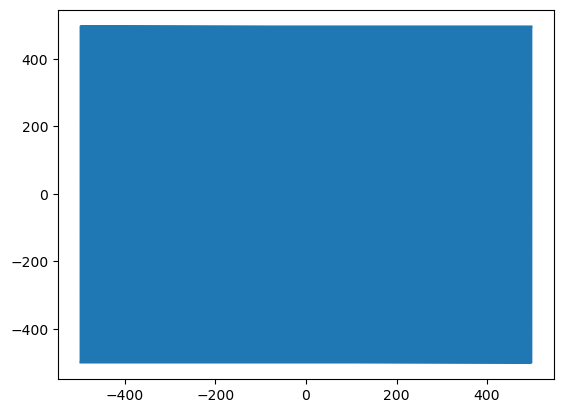

Number of blocks: 1280
Number of events:
RF:    256
Gx:    768
Gy:    512
Gz:    768
ADC:    256
Delay:    512
Sequence duration: 3.072000 s
TE: 0.005006 s
TR: 0.012000 s
Flip angle: 10.00 deg
Unique k-space positions (aka cols, rows, etc.): 256 256 
Dimensions: 2
Spatial resolution: 1.00 mm
Spatial resolution: 1.00 mm
Repetitions/slices/contrasts: 1.0
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 4039983 537634 3291667 Hz/m == 94.89 12.63 77.31 mT/m
Max slew rate: 8329862557 8470394737 8333333333 Hz/m/s == 195.65 198.95 195.73 mT/m/s
Max absolute gradient: 4847798 Hz/m == 113.86 mT/m
Max absolute slew rate: 1.45113e+10 Hz/m/s == 340.83 T/m/s


In [13]:
# ======
# VISUALIZATION
# ======
if plot:
    seq.plot()

# Calculate and visualize k-space
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()
plt.figure(1)
plt.plot(k_traj_adc[0,:],k_traj_adc[1,:])
plt.show()

# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within slew-rate limits
rep = seq.test_report()
print(rep)

In [14]:
# =========
# WRITE .SEQ
# =========
if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition("FOV", [fov, fov, slice_thickness])
    seq.set_definition("Name", "gre")
    # Had to change keyword arguments to just positional arguments.

    seq.write(seq_filename)